# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Project Overview

Starbucks often sends promotions to its custoners.  Normally, there are 3 different types of promotions: Buy One Get One Free (BOGO), Discount or Informational.  Not all customers get the same offer.  In this project, I would like to analyze the 3 data files provided by Starbucks/Udacity, build a data model to predict a customer's response to an offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Check portfolio data file
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
# split channel into different attribute
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))

for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

# Drop "channels" column
portfolio = portfolio.drop('channels', axis=1)

# Rename 'id' column to 'offer_id'
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# Change the unit of 'duration' column from days to hours
portfolio['duration'] = portfolio['duration']*24
portfolio

,difficulty,duration,offer_id,offer_type,reward,mobile,social,email,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [4]:
# check profile data file
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [5]:
# check nan value
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [6]:
# Replace nan with avg for "income", replace nan with N/A for "gender"
profile['income'].fillna((profile['income'].mean()), inplace=True)
profile['gender'].fillna('NA', inplace=True)

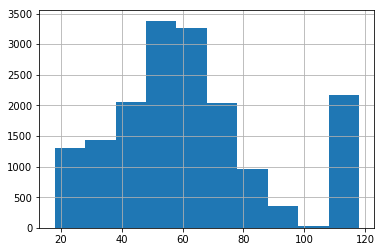

In [7]:
# check distribution of age column
profile.age.hist()

Starbucks customers are from teenagers to senior citizens, most of the customers are between 30 years old and 78 years old.

In [8]:
# check the # of customers at age = '118'
profile['age'][profile['age'] == 118].count()

2175

In [9]:
# check # of male customers vs. # of female customers
profile.gender.value_counts()

M     8484
F     6129
NA    2175
O      212
Name: gender, dtype: int64

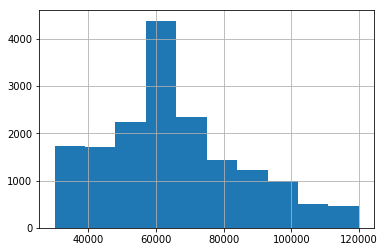

In [10]:
# check distribution of 'income' column
profile['income'].hist()

The customers’ income ranges from less than $30,000 to about $120,000, the majority is between $50,000 to about $75,000.

In [11]:
# check transcript data file
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


# Data Processing

Create a new portfolio data file by normalizing “reward” and “difficulty” values and changing the “offer_id”, “offer_type” value to a more “user friendly” numerical value based upon the category

In [12]:
new_portfolio = portfolio.copy()
new_portfolio.rename(columns={'duration': 'duration_hours'}, inplace=True)

# Normalize 'difficulty'and 'reward' features using MinMaxScaler
scaler = MinMaxScaler()
numerical = ['difficulty', 'reward']

new_portfolio[numerical] = scaler.fit_transform(new_portfolio[numerical])

new_portfolio.head()

,difficulty,duration_hours,offer_id,offer_type,reward,mobile,social,email,web
0,0.50,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.0,1,1,1,0
1,0.50,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.0,1,1,1,1
2,0.00,96,3f207df678b143eea3cee63160fa8bed,informational,0.0,1,0,1,1
3,0.25,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.5,1,0,1,1
4,1.00,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.5,0,0,1,1


In [13]:
# Replace 'offer_id' with numerical # for easy analysis later on
offer_id = new_portfolio['offer_id'].astype('category').cat.categories.tolist()
replace_offer_id = {'offer_id': {k: v for k,v in zip(offer_id,list(range(1,len(offer_id)+1)))}}
replace_offer_id

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

In [14]:
# replace 'offer_type' with numerical # for easy analysis later on
offer_type = new_portfolio['offer_type'].astype('category').cat.categories.tolist()
replace_offer_type = {'offer_type': {k: v for k,v in zip(offer_type, list(range(1, len(offer_type)+1)))}}
replace_offer_type

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}

In [15]:
new_portfolio.replace(replace_offer_type, inplace=True)

In [16]:
new_portfolio

,difficulty,duration_hours,offer_id,offer_type,reward,mobile,social,email,web
0,0.50,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1.0,1,1,1,0
1,0.50,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1.0,1,1,1,1
2,0.00,96,3f207df678b143eea3cee63160fa8bed,3,0.0,1,0,1,1
3,0.25,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0.5,1,0,1,1
4,1.00,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,0.5,0,0,1,1
5,0.35,168,2298d6c36e964ae4a3e7e9706d1fb8c2,2,0.3,1,1,1,1
6,0.50,240,fafdcd668e3743c1bb461111dcafc2a4,2,0.2,1,1,1,1
7,0.00,72,5a8bc65990b245e5a138643cd4eb9837,3,0.0,1,1,1,0
8,0.25,120,f19421c1d4aa40978ebb69ca19b0e20d,1,0.5,1,1,1,1
9,0.50,168,2906b810c7d4411798c6938adc9daaa5,2,0.2,1,0,1,1


In [17]:
new_portfolio.replace(replace_offer_id, inplace=True)
new_portfolio

,difficulty,duration_hours,offer_id,offer_type,reward,mobile,social,email,web
0,0.50,168,8,1,1.0,1,1,1,0
1,0.50,120,5,1,1.0,1,1,1,1
2,0.00,96,4,3,0.0,1,0,1,1
3,0.25,168,7,1,0.5,1,0,1,1
4,1.00,240,1,2,0.5,0,0,1,1
5,0.35,168,2,2,0.3,1,1,1,1
6,0.50,240,10,2,0.2,1,1,1,1
7,0.00,72,6,3,0.0,1,1,1,0
8,0.25,120,9,1,0.5,1,1,1,1
9,0.50,168,3,2,0.2,1,0,1,1


Create a new profile data file with the following changes:
1. Rename “id” column name to “customer_id” in order to merge with the other data file later on
2. Drop all the rows with no “age”, “gender” or “income” value
3. Change the datatype to “int” for both “age” and “income”
4. Define the age group into 4 groups: teenager, young adult, adult and elderly
5. Create a new column for “age group”, map the customers into different age groups based upon their ages
6. Define the income into 3 ranges: average, above average and high
7. Create a new column for “income range” , map the customers into different income groups based upon their income
8. Define the gender into 3 categories: M, F and O, and map the customers into different gender groups

In [18]:
new_profile = profile.copy()

# rename 'id' column to 'customer_id'
new_profile.rename(columns= {'id':'customer_id'}, inplace=True)

# replace 'customer_id' string value with numerical values for easy analysis later on
id = new_profile['customer_id'].astype('category').cat.categories.tolist()
replace_customer_id = {'customer_id' : {k: v for k, v in zip(id, list(range(1, len(id)+1)))}}

new_profile.replace(replace_customer_id, inplace=True)

new_profile

,age,became_member_on,gender,customer_id,income
0,118,20170212,NA,6962,65404.991568
1,55,20170715,F,399,112000.000000
2,118,20180712,NA,3747,65404.991568
3,75,20170509,F,7997,100000.000000
4,118,20170804,NA,10736,65404.991568
5,68,20180426,M,15044,70000.000000
6,118,20170925,NA,9525,65404.991568
7,118,20171002,NA,6940,65404.991568
8,65,20180209,M,3729,53000.000000
9,118,20161122,NA,9147,65404.991568


In [19]:
# replace age = '118' with NaN value, drop rows with NaN values in 'age', 'gender', 'income'
new_profile['age'] = new_profile['age'].apply(lambda x: np.nan if x == 118 else x)
new_profile.dropna(inplace=True)
new_profile.isna().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
dtype: int64

In [21]:
# change datatype of 'age' and 'income' to 'int' for easy analysis later on
new_profile[['age','income']] = new_profile[['age', 'income']].astype(int)

# create a new category for 'age_group'
new_profile['age_group'] = pd.cut(new_profile['age'], bins=[16, 25, 40, 70, 105], labels=['teenager', 'young_adult', 'adult', 'elderly'])

# replace 'age_group' with numerical value for easy analysis later on
age_group = new_profile['age_group'].astype('category').cat.categories.tolist()
replace_age_group = {'age_group' : {k: v for k, v in zip(age_group, list(range(1, len(age_group)+1)))}}

replace_age_group

{'age_group': {'teenager': 1, 'young_adult': 2, 'adult': 3, 'elderly': 4}}

In [22]:
# replace the 'age_group' column with the new value
new_profile.replace(replace_age_group, inplace=True)
new_profile['age_group']

1        3
3        4
5        3
8        3
12       3
13       3
14       2
15       3
16       3
18       3
19       3
20       2
21       3
22       4
24       3
25       3
27       2
28       3
29       3
30       3
31       3
32       1
33       4
34       2
35       3
37       3
38       2
40       4
41       1
42       3
        ..
16963    3
16964    3
16965    3
16966    3
16967    3
16968    4
16970    3
16971    3
16972    3
16973    2
16974    3
16975    3
16976    2
16978    2
16979    3
16981    4
16983    4
16984    4
16985    2
16986    3
16987    3
16988    3
16990    3
16992    1
16993    3
16995    3
16996    3
16997    3
16998    4
16999    3
Name: age_group, Length: 14825, dtype: int64

In [23]:
# Separate income into different range
new_profile['income_range'] = pd.cut(new_profile['income'], bins=[30000, 60000, 90000, 120100], labels=['average', 'above_average', 'high'])

income_range = new_profile['income_range'].astype('category').cat.categories.tolist()
replace_income_range = {'income_range': {k: v for k, v in zip(income_range, list(range(1, len(income_range)+1)))}}

replace_income_range

{'income_range': {'average': 1, 'above_average': 2, 'high': 3}}

In [24]:
new_profile.replace(replace_income_range, inplace=True)

In [25]:
# Replace 'gender' category with numerical label
gender = new_profile['gender'].astype('category').cat.categories.tolist()
replace_gender = {'gender' : {k: v for k, v in zip(gender, list(range(1, len(gender)+1)))}}

new_profile.replace(replace_gender, inplace=True)

In [26]:
new_profile.head()

,age,became_member_on,gender,customer_id,income,age_group,income_range
1,55,20170715,1,399,112000,3,3.0
3,75,20170509,1,7997,100000,4,3.0
5,68,20180426,2,15044,70000,3,2.0
8,65,20180209,2,3729,53000,3,1.0
12,58,20171111,2,3060,51000,3,1.0


In [27]:
# Change the datatype of 'became_member_on' from int to date 
import datetime
new_profile['became_member_on'] = pd.to_datetime(new_profile['became_member_on'], format = '%Y%m%d')
new_profile['membership_year'] = new_profile['became_member_on'].dt.year
new_profile['membership_days'] = datetime.datetime.today().date() - new_profile['became_member_on'].dt.date
new_profile['membership_days'] = new_profile['membership_days'].dt.days

new_profile.head()

,age,became_member_on,gender,customer_id,income,age_group,income_range,membership_year,membership_days
1,55,2017-07-15,1,399,112000,3,3.0,2017,1346
3,75,2017-05-09,1,7997,100000,4,3.0,2017,1413
5,68,2018-04-26,2,15044,70000,3,2.0,2018,1061
8,65,2018-02-09,2,3729,53000,3,1.0,2018,1137
12,58,2017-11-11,2,3060,51000,3,1.0,2017,1227


Create a new transcript data file with the following changes:
1. Rename “person” column to “customer_id” in order to merge with the other data files later on
2. Replace the value of “customer_id” with the category id that I create with “profile” data file
3. Since there are multiple values in “value” column, separate them into multiple columns: offer_id, amount, reward. Then fill in the value of “offer_id” with the one I create in new “portfolio” file. Drop the duplicated offer id column and also the “value” column

In [28]:
new_transcript = transcript.copy()

# rename 'person' column to 'customer_id'
new_transcript.rename(columns={'person': 'customer_id'}, inplace=True)
new_transcript.replace(replace_customer_id, inplace=True)

new_transcript.head()

,event,customer_id,time,value
0,offer received,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:
# Separate multiple keys in 'value' column
keys = []
for idx, row in new_transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)
            
keys

['offer id', 'amount', 'offer_id', 'reward']

In [30]:
# create new columns for each key
new_transcript['offer_id'] = ''
new_transcript['amount'] = 0
new_transcript['reward'] = 0

for idx, row in new_transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            new_transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            new_transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            new_transcript.at[idx, 'reward'] = row['value'][k]
            
# fill all NaN in 'offer_id' with 'N/A' values
new_transcript['offer_id'] = new_transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

# drop 'value' column
new_transcript.drop('value', axis=1, inplace=True)

new_transcript.head()

,event,customer_id,time,offer_id,amount,reward
0,offer received,7997,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,10736,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,15044,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,9525,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,6940,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


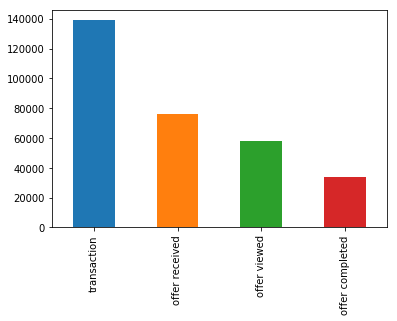

In [31]:
# Let's take a look at the events
# Visualize the events
new_transcript['event'].value_counts().plot(kind='bar')
plt.show()

In [32]:
# I am only interested in "offer viewed" and "offer completed"
# exclude all 'transaction' and "offer received" events
new_transcript = new_transcript[new_transcript['event'] != 'transaction']
new_transcript = new_transcript[new_transcript['event'] != 'offer received']

# replace 'event' category with numbers
event = new_transcript['event'].astype('category').cat.categories.tolist()
replace_event = {'event' : {k: v for k, v in zip(event, list(range(1, len(event)+1)))}}

new_transcript.replace(replace_event, inplace=True)
new_transcript.replace(replace_offer_id, inplace=True)

In [33]:
new_transcript.head()

,event,customer_id,time,offer_id,amount,reward
12650,2,3729,0,9,0,0
12651,2,13995,0,6,0,0
12652,2,1052,0,5,0,0
12653,2,170,0,8,0,0
12655,2,12744,0,6,0,0


In [34]:
# merge 3 new data files into one data file
merged_df = new_transcript.merge(new_portfolio, how='left', on='offer_id')
merged_df = merged_df.merge(new_profile, how='left', on='customer_id')

merged_df.head()

,event,customer_id,time,offer_id,amount,reward_x,difficulty,duration_hours,offer_type,reward_y,...,email,web,age,became_member_on,gender,income,age_group,income_range,membership_year,membership_days
0,2,3729,0,9,0,0,0.25,120,1,0.5,...,1,1,65.0,2018-02-09,2.0,53000.0,3.0,1.0,2018.0,1137.0
1,2,13995,0,6,0,0,0.00,72,3,0.0,...,1,0,53.0,2017-09-16,3.0,52000.0,3.0,1.0,2017.0,1283.0
2,2,1052,0,5,0,0,0.50,120,1,1.0,...,1,1,69.0,2016-08-14,1.0,57000.0,3.0,1.0,2016.0,1681.0
3,2,170,0,8,0,0,0.50,168,1,1.0,...,1,0,20.0,2016-07-11,1.0,30000.0,1.0,NaN,2016.0,1715.0
4,2,12744,0,6,0,0,0.00,72,3,0.0,...,1,0,39.0,2014-05-27,2.0,51000.0,2.0,1.0,2014.0,2491.0


In [35]:
merged_df.dropna(inplace=True)

In [36]:
# change the values from #s to more meaningful values
merged_df['offer_type'] = merged_df['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})
#merged_df['income_range'] = merged_df['income_range'].map({1: 'Average', 2: 'Above Average', 3: 'High'})
merged_df['age_group'] = merged_df['age_group'].map({1: 'Teenager', 2: 'Young Adult', 3: 'Adult', 4: 'Senior'})

Question 1: What is the most popular promotion for male vs. female?

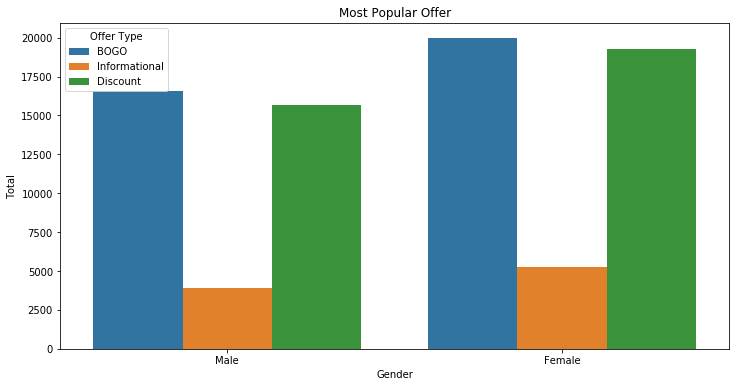

In [38]:
import seaborn as sns
plt.figure(figsize=(12, 6))
d = sns.countplot(x='gender', hue='offer_type', data=merged_df[merged_df['gender'] != 3])
plt.title('Most Popular Offer')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Male', 'Female']
d.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show()

Question 2: What is the most popular promotion for different age groups?

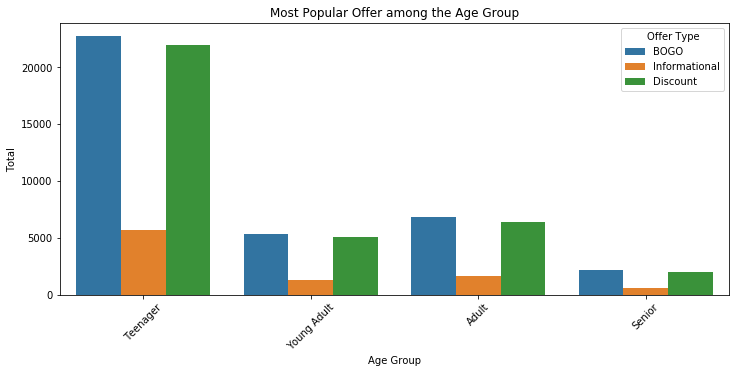

In [40]:
plt.figure(figsize=(12, 5))
d = sns.countplot(x='age_group', hue='offer_type', data=merged_df)
plt.title('Most Popular Offer among the Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['Teenager', 'Young Adult', 'Adult', 'Senior']
d.set_xticklabels(xlabels)
plt.xticks(rotation=45)
plt.legend(title='Offer Type')
plt.show()

In [41]:
offer_type1 = merged_df['offer_type'].astype('category').cat.categories.tolist()
replace_offer_type1 = {'offer_type': {k: v for k, v in zip(offer_type1, list(range(1, len(offer_type1)+1)))}}

merged_df.replace(replace_offer_type1, inplace=True)
merged_df.replace(replace_age_group, inplace=True)

Now, I have a cleaned and merged data file, I can start to build the data model.

# Data Modeling

Let's build a model that could help to predict how a particular customer will respond to an offer.

In [42]:
# Split the data into features vs. target
features = merged_df[['time', 'offer_id', 'amount','reward_x', 'offer_type', 'gender', 'income']]
target = merged_df['offer_type']

features.head()

,time,offer_id,amount,reward_x,offer_type,gender,income
0,0,9,0,0,1,2.0,53000.0
1,0,6,0,0,3,3.0,52000.0
2,0,5,0,0,1,1.0,57000.0
4,0,6,0,0,3,2.0,51000.0
5,0,3,0,0,2,2.0,96000.0


In [43]:
# normalizing "time", "amount", "reward_x", "income" since I use them as features
scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward_x', 'income']

features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,time,offer_id,amount,reward_x,offer_type,gender,income
0,0.0,9,0.0,0.0,1,2.0,0.247191
1,0.0,6,0.0,0.0,3,3.0,0.235955
2,0.0,5,0.0,0.0,1,1.0,0.292135
4,0.0,6,0.0,0.0,3,2.0,0.224719
5,0.0,3,0.0,0.0,2,2.0,0.730337


In [44]:
# Create train & test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

print('Training Features Shape:', X_train.shape)
print('Traing Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (61441, 7)
Traing Labels Shape: (61441,)
Testing Features Shape: (20481, 7)
Testing Labels Shape: (20481,)


In [45]:
# build a function to predict then use different algorithms to validate
def predict(model):
    pred = model.predict(X_test)
    
    errors = abs(pred - y_test)
    
    mean_ape = 100 * (errors/y_test)
    accu = 100 - np.mean(mean_ape)
    
    return round(accu, 4)

1. Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

RF.fit(X_train, y_train)
print(f'Training Accuracy with Random Forest: {round(RF.score(X_train, y_train)*100, 2)}%')
print(f'Prediction Accuracy with Random Forest: {predict(RF)}%')

Training Accuracy with Random Forest: 100.0%
Prediction Accuracy with Random Forest: 100.0%


2. K-Nearest Neighbors

In [47]:
KNN = KNeighborsClassifier()

KNN.fit(X_train, y_train)
print(f'Training Accuracy with K-Nearest Neighbors: {round(KNN.score(X_train, y_train)*100, 2)}%')
print(f'Prediction Accuracy with K-Nearest Neighbors: {predict(KNN)}%')

Training Accuracy with K-Nearest Neighbors: 100.0%
Prediction Accuracy with K-Nearest Neighbors: 100.0%


3. Decision Tree

In [48]:
DT = DecisionTreeClassifier()

DT.fit(X_train, y_train)
print(f'Training Accuracy with Decision Tree: {round(DT.score(X_train, y_train)*100, 2)}%')
print(f'Prediction Accuracy with Decision Tree: {predict(DT)}%')

Training Accuracy with Decision Tree: 100.0%
Prediction Accuracy with Decision Tree: 100.0%


# Conclusion

In this project, I analyzed the data sets provided by Starbucks, and tried to build a model to predict a customer's response to an offer.  

I started with exploring the data set to understand the provided data, check the missing value.  Then pre-processing the data set to get the clean data for each data file.  The pre-processing took a lot of effort because the data has missing values, mismatch data types, and multiple values in one column.  Once the data are cleaned, I was able to merge them into one data file to do analysis then build the model.

Here are some findings:
1. The most popular offer among all age groups is the BOGO, followed by the Discount offers.  
2. According to the available data, there are 3 'gender' categories (M, F and O), and there are 2175 missing values in that data file.
3. Customers income ranges from 30,000 to 120,000 with most of the customers' incomes fall between 50,000 and 75,000.
4. Both genders like BOGO and Discount offers.

# Reflection

Doing this project was a challenge, especially the pre-processing part to separate multiple value into different columns, and replacing values with numbers, which took a lot of my time, it is also interesting because I learned a lot by doing it.  

It has been a jouney and I enjoyed every bit of it! 

# Improvements

Although the prediction models have very good results, I think this is due to large amount of missing data.  If more data can be collected or less missing data, we might be able to build a model that can predict which kind of offers to be sent to what group of customers(e.g. age group, income range ... etc.).